# Impact of rainfall temporal distribution on flooding in Lin Dyke catchment


## Project Summary

Research suggests that the temporal distribution of rainfall within a storm event can influence the nature and severity of flooding resulting from that storm event....

Testing this using synthetic rainfall events derived from FEH/ReFH2. Standard profiles usually have one peak, testing three methods for splitting the total rainfall amount normally concentrated in this one peak into multiple peaks 

Analysing impact on the extent, depth and velocity of flooding, and the spatial distribution of these variables over the catchment

In [1]:
import os
from pathlib import Path
from PIL import Image
import geopandas as gpd
from my_functions_new import *

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Define whether to filter out values <0.1
remove_little_values = True

model_directory = '../../../../FloodModelling/MeganModel_New/'

### Plot the clusters

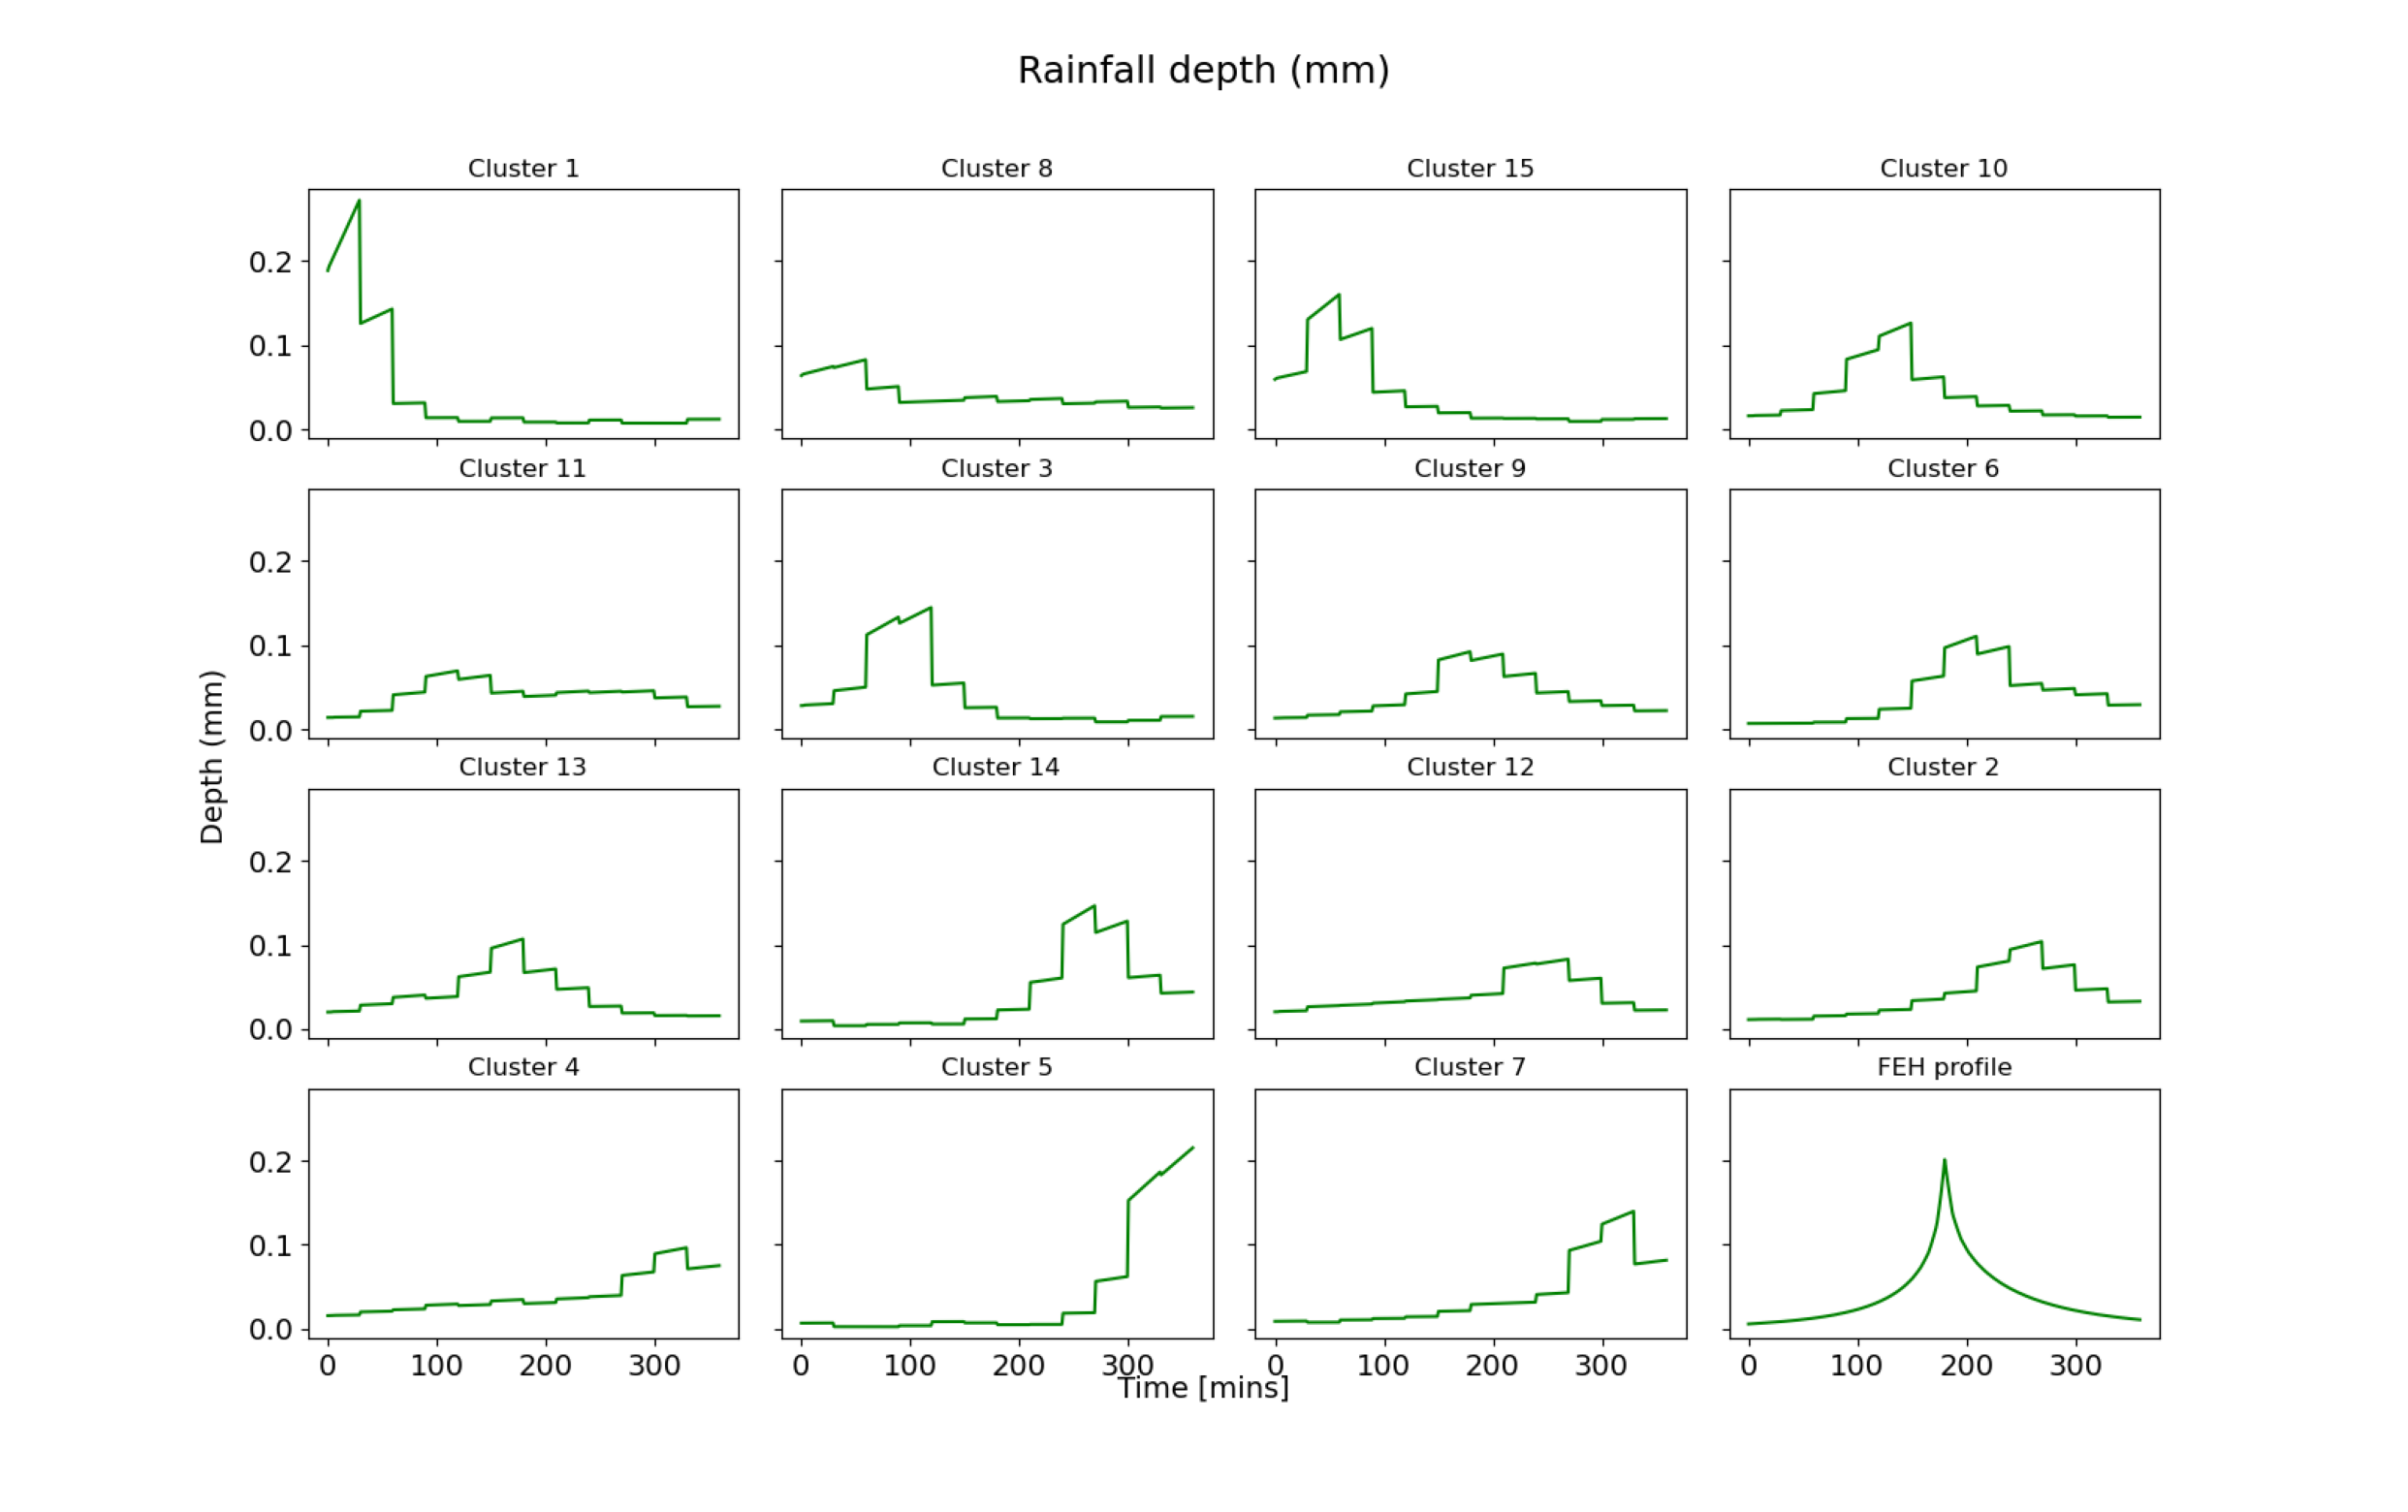

In [2]:
fig,ax =plt.subplots(figsize=(40,20))
img = Image.open("../../CreateSyntheticRainfallEvents/ObservedProfiles/6hr_100yrRP/PostLossRemoval/clusters_ordered_by_loadingstyle.png")
plt.axis('off')
plt.imshow(img);

### Get version of landcover array with just 'urban' and 'rural' categories

In [7]:
# Read in the data
landcover, out_meta = prepare_rainfall_scenario_raster(model_directory + "LandCover_clipped.tif", True)
# Convert the 1 and 6 values to 10 (for urban) and the rest to 11 (for non-urban).  
landcover_mod =  np.where(landcover==1, 10, landcover)
landcover_mod =  np.where(landcover_mod==6, 10, landcover_mod)
# Convert the rest of the classes to 11
for i in [1,2,3,4,5,7,8,9]:
    landcover_mod =  np.where(landcover_mod==i, 11, landcover_mod)

### Define the names of the method (shorter and longer versions)

In [8]:
short_ids = ['6h_sp','6h_c1','6h_c2','6h_c3','6h_c4', '6h_c5', '6h_c6','6h_c7',
            '6h_c8','6h_c9', '6h_c10', '6h_c11','6h_c12','6h_c13','6h_c14', '6h_c15']   
methods = ['6h_single-peak', 'Cluster1', 'Cluster2', 'Cluster3', 'Cluster4', 'Cluster5', 'Cluster6', 'Cluster7', 'Cluster8',
           'Cluster9','Cluster10', 'Cluster11',  'Cluster12','Cluster13', 'Cluster14', 'Cluster15']  

### Find maximum intensity for each method and minute in which it occurs (to use in sorting results analysis)

In [9]:
maxs = []
min_of_maxs = []

# Add FEH data
feh_precip=pd.read_csv("../../CreateSyntheticRainfallEvents/ReFH2_singlepeak/6hr_100yrRP/PostLossRemoval/6h_feh_singlepeak.csv")
maxs.append(feh_precip["Total net rain mm (Observed rainfall - 01/08/2022) - urbanised model"].max())
min_of_maxs.append(feh_precip["Total net rain mm (Observed rainfall - 01/08/2022) - urbanised model"].idxmax())

#Add observed profile data
for cluster_num in range(1,16):
    precip=pd.read_csv("../../CreateSyntheticRainfallEvents/ObservedProfiles/6hr_100yrRP/PostLossRemoval/cluster{}_urban_summer.csv".format(cluster_num))
    maxs.append(precip["Total net rain mm (Observed rainfall - 01/08/2022) - urbanised model"].max())
    min_of_maxs.append(precip["Total net rain mm (Observed rainfall - 01/08/2022) - urbanised model"].idxmax())

### Create versions of lists of methods, in order based on max intensity and the the timing of the max intensity 

In [10]:
short_ids_by_loading=  pd.DataFrame({"min": min_of_maxs, 'cluster_num': short_ids}).sort_values('min')["cluster_num"].tolist()
short_ids_by_loading.remove('6h_sp')
short_ids_by_loading = ['6h_sp']+short_ids_by_loading

short_ids_by_intensity = pd.DataFrame({"min": maxs, 'cluster_num': short_ids}).sort_values('min', ascending = False)["cluster_num"].tolist()
short_ids_by_intensity.remove('6h_sp')
short_ids_by_intensity = ['6h_sp']+short_ids_by_intensity

### Create dataframe of colours for each cluster (based on their loading)

In [11]:
colours = create_colours_df(short_ids)

NameError: name 'create_colours_df' is not defined

### Create list of filepaths, formatted to be used for either depth or velocity

In [12]:
fps = []
for method_num, short_id in enumerate(short_ids):
    fp = model_directory + "{}/{} (Max).Resampled.Terrain.tif".format(short_id, '{}')
    fps.append(fp)

### Define breaks for categorising velocity and depth

In [13]:
# Define breaks to split the depths/velocities on
breaks_depths = np.array([0, 0.3, 0.6, 1.2, 100])  
labels_depth = ['<=0.3m', '0.3-0.6m', '0.6-1.2m', '>1.2m']
breaks_velocity = np.array([0,0.25,0.5,2,100])
labels_velocity = ["<=0.25m/s", "0.25-0.5m/s", "0.5-2m/s", ">2m/s"]

# <u> Flood extent </u>
To examine whether the rainfall's temporal distribution influences the total extent of flooding, the number of flooded cells and the total flooded area in km2 (incl. only cells with depth >0.1m) is compared between the profile with a single peak, and the three methods for producing multi-peaked rainfall events. 

### Create dataframes containing the (total/urban) flooded area in each depth/velocity bin

In [ ]:
velocity_counts, velocity_props = create_binned_counts_and_props(fps, 'Velocity', breaks_velocity, labels_velocity, remove_little_values)
depth_counts, depth_props = create_binned_counts_and_props(fps, 'Depth', breaks_depths, labels_depth, remove_little_values)

velocity_counts_urban, velocity_props_urban = create_binned_counts_and_props_urban(fps, 'Velocity', breaks_velocity, labels_velocity, remove_little_values, landcover_mod)
depth_counts_urban, depth_props_urban = create_binned_counts_and_props_urban(fps, 'Depth', breaks_depths, labels_depth, remove_little_values, landcover_mod)

### Create dataframes containing the (total/urban) flooded area

In [ ]:
totals_df = create_totals_df(velocity_counts)
totals_df_urban = create_totals_df(velocity_counts_urban)      

### Create dataframes containing the % diff in the flooded area between single peak and each other method  

In [171]:
percent_diffs_df = find_percentage_diff (totals_df, fps, short_ids) 
percent_diffs_df_urban = find_percentage_diff (totals_df_urban, fps, short_ids)   

### Check whether the proportion of flooded cells in urban areas changes between methods
(It doesn't; roughly 33% throughout)

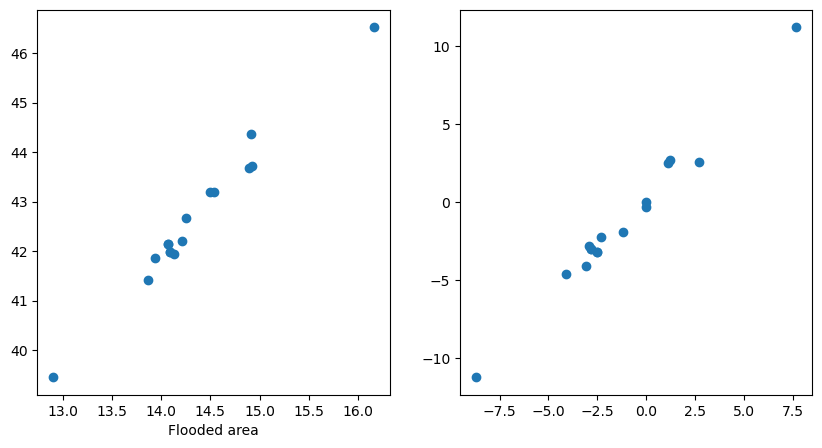

In [192]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (10,5))
# The urban flooded area as a percentage of the total area 
axs[0].scatter(cluster_results['UrbanFloodedArea'], cluster_results['TotalFloodedArea']);
axs[0].set_xlabel('Flooded area')
(cluster_results['UrbanFloodedArea']/cluster_results['TotalFloodedArea'])*100
# The difference between the flooded area from a method and single peak 
axs[1].scatter(cluster_results['%Diff_FloodedArea_fromSP'], cluster_results['%Diff_UrbanFloodedArea_fromSP']);

In [172]:
cluster_results = pd.DataFrame({'Cluster_num': short_ids, "MaxRainfallIntensity": maxs,  
    "MaxRainfallIntensityMinute": min_of_maxs,
   'TotalFloodedArea':totals_df.T[0],'%Diff_FloodedArea_fromSP':percent_diffs_df.T['percent_diffs'],
    'Abs%Diff_FloodedArea_fromSP':percent_diffs_df.T['percent_diffs_abs'],'UrbanFloodedArea':totals_df_urban.T[0],
   '%Diff_UrbanFloodedArea_fromSP':percent_diffs_df_urban.T['percent_diffs'],
   'Abs%Diff_UrbanFloodedArea_fromSP':percent_diffs_df_urban.T['percent_diffs_abs']}) 

## Plot the flooded area 

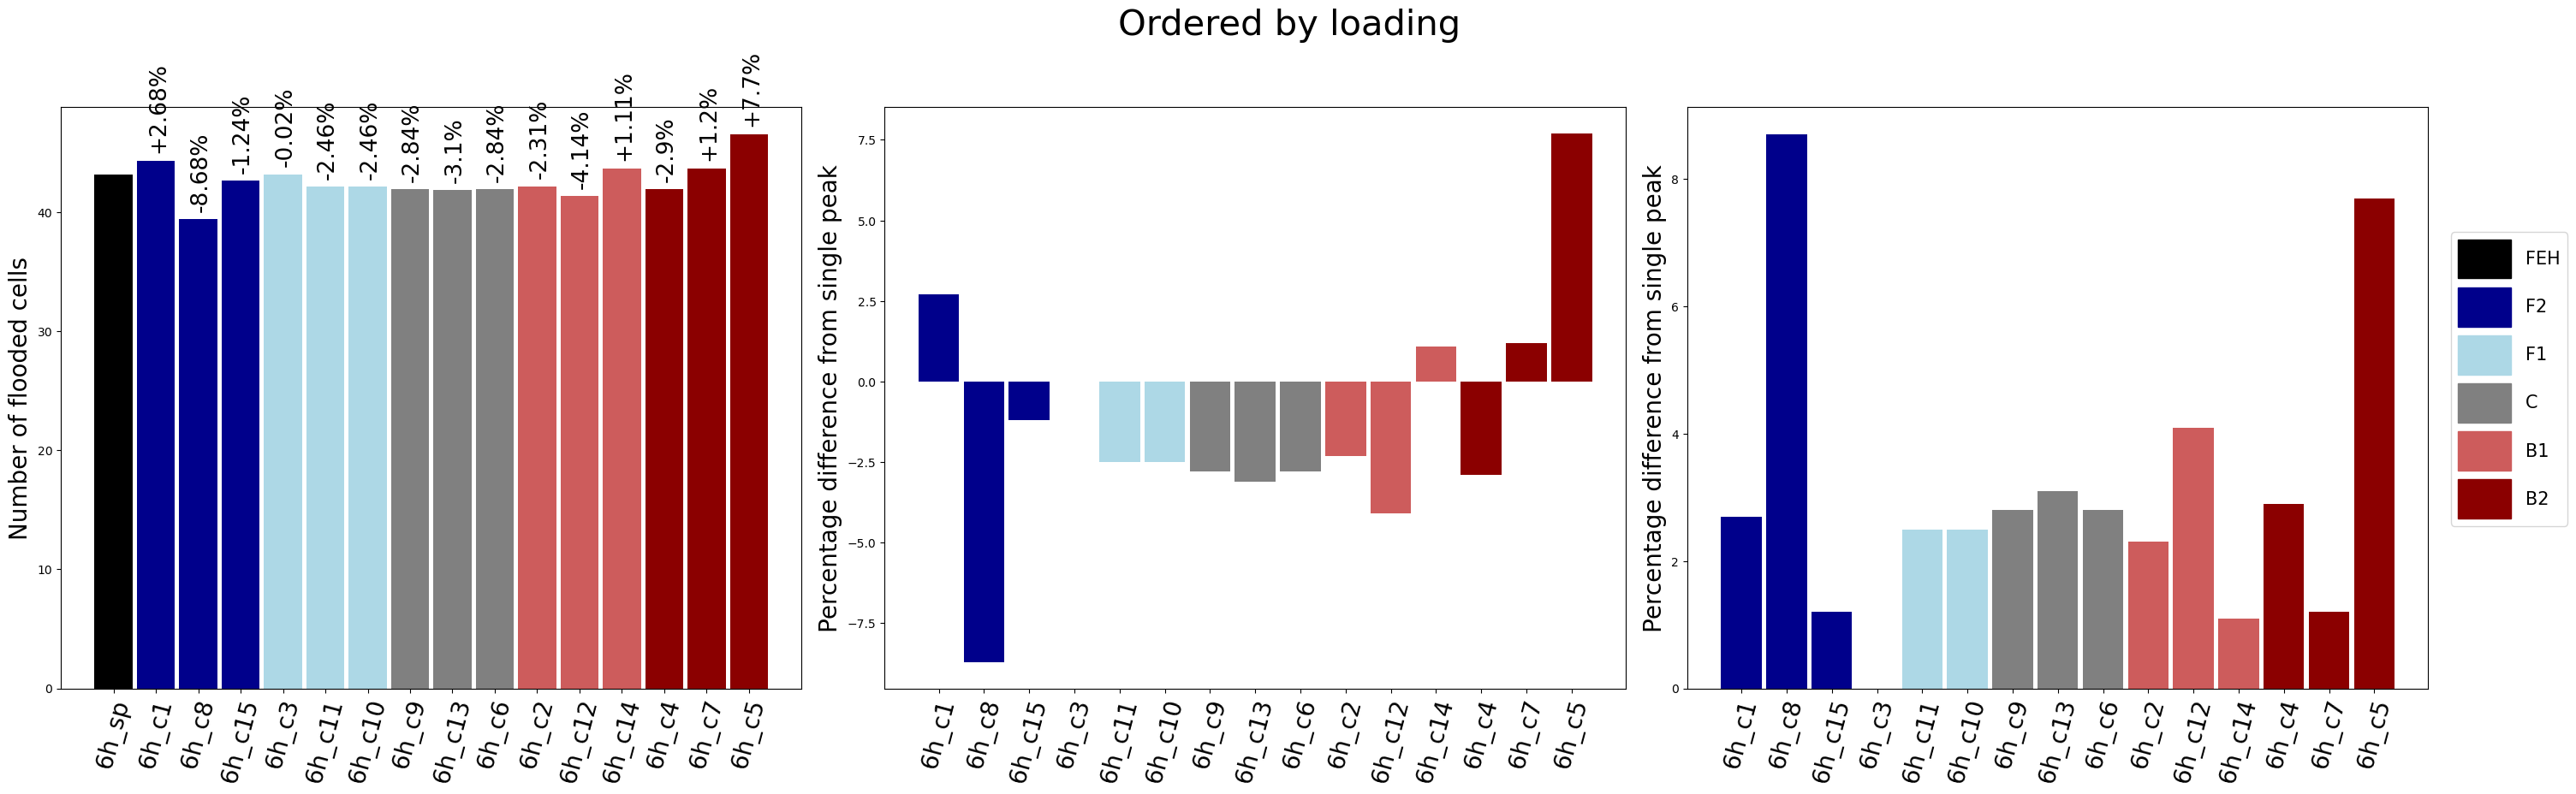

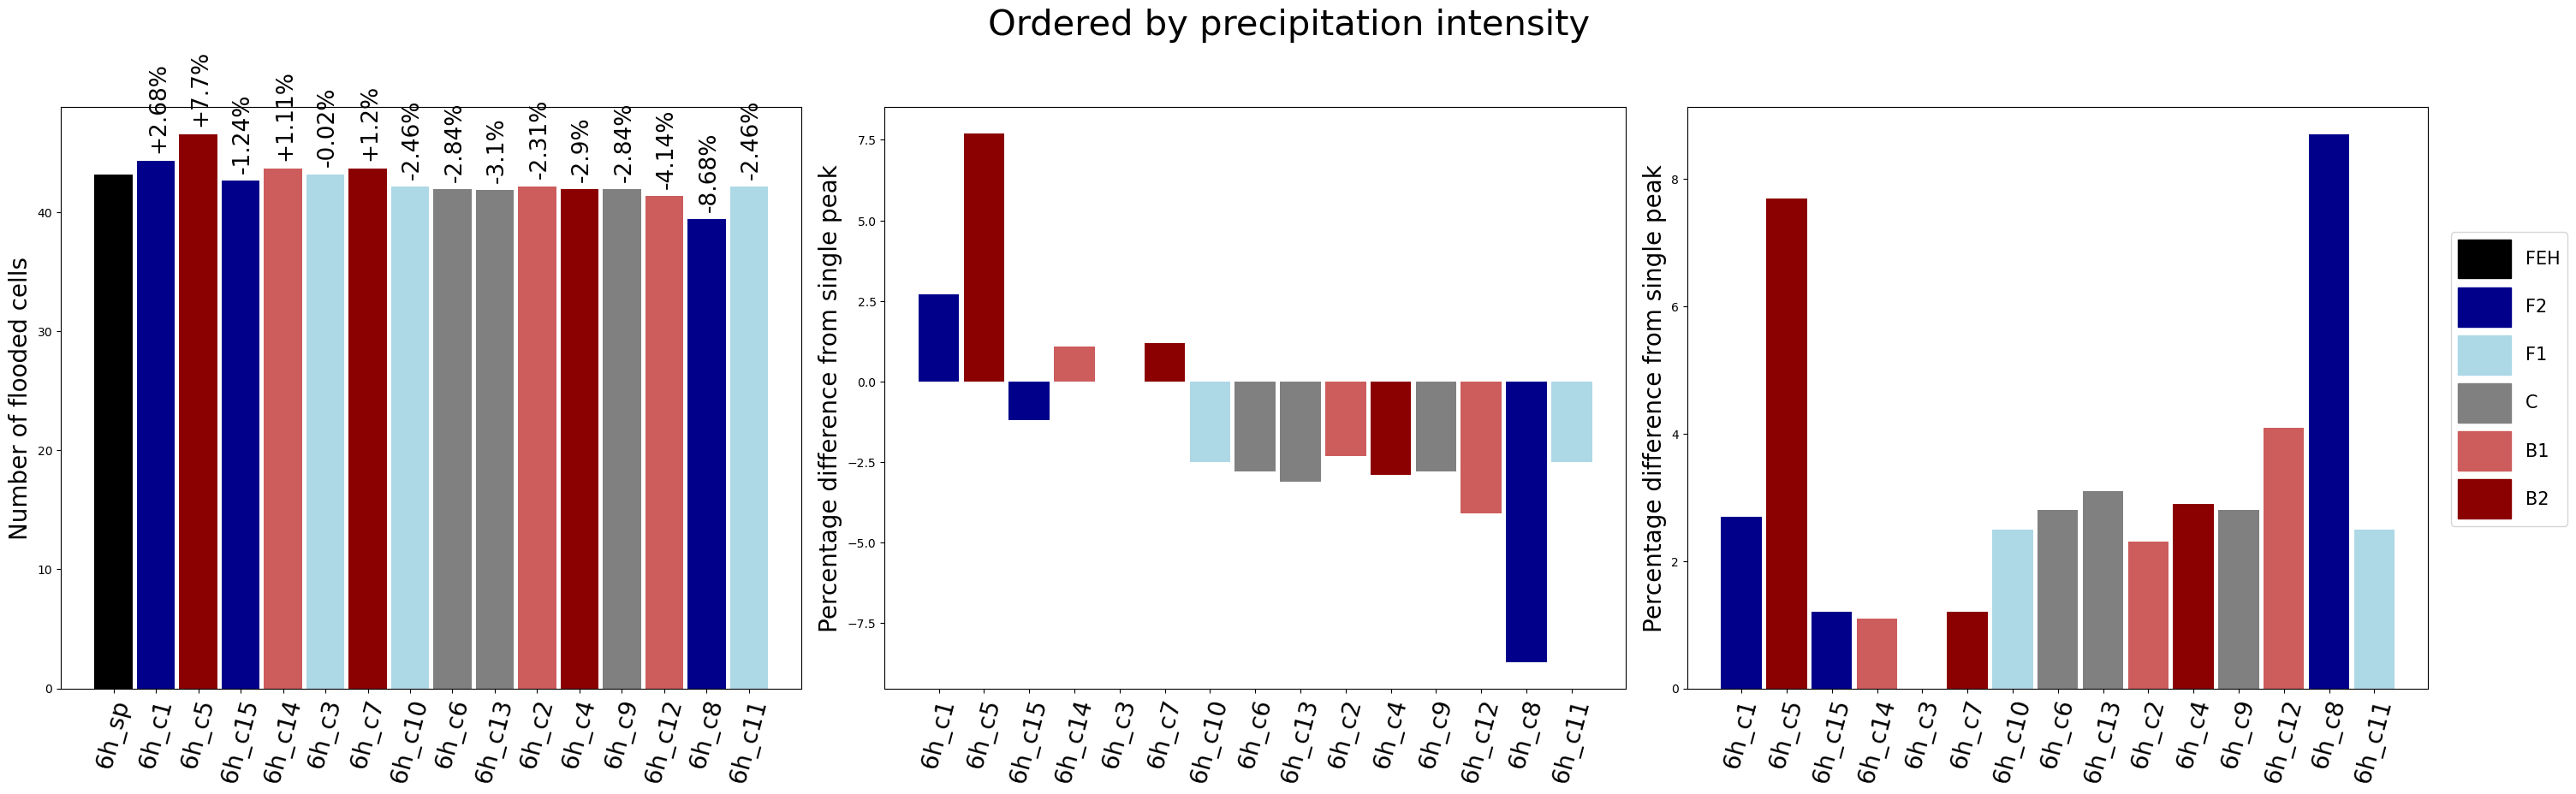

In [174]:
plot_totals(totals_df, percent_diffs_df, short_ids_by_loading, 'Ordered by loading', colours)
plot_totals(totals_df, percent_diffs_df, short_ids_by_intensity, 'Ordered by precipitation intensity', colours)

### Plot the maximum peak intensity value against the flooded area

In [ ]:
# difference_postloss_removal = find_difference_stats(post_loss_removal_dict, 'Total net rain mm (Observed rainfall - 01/08/2022) - urbanised model', 'Total net rain mm (Observed rainfall - 01/08/2022) - urbanised model',  single_peak_postlossremoval)

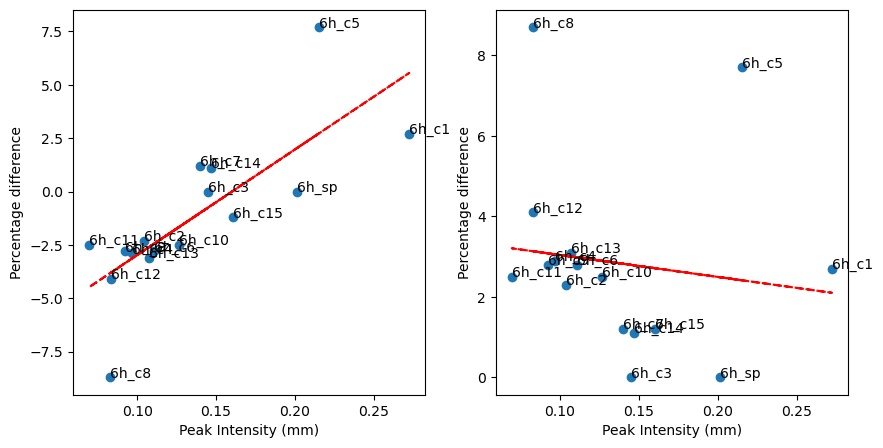

In [38]:
cols =cluster_results['Cluster_num'].tolist()
peak_intensities = cluster_results['MaxRainfallIntensity'].tolist()
perc_diffs = cluster_results['%Diff_FloodedArea_fromSP'].tolist()
abs_perc_diffs = cluster_results['Abs%Diff_FloodedArea_fromSP'].tolist()

fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (10,5))
scatter_plot_with_trend_line(axs[0], peak_intensities, perc_diffs, 'Peak Intensity (mm)' , 'Percentage difference')
scatter_plot_with_trend_line(axs[1], peak_intensities, abs_perc_diffs, 'Peak Intensity (mm)' , 'Percentage difference')

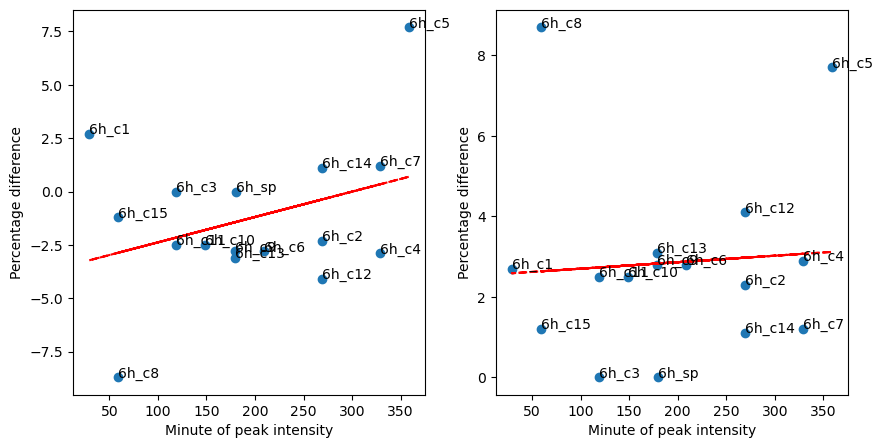

In [40]:
cols =cluster_results['Cluster_num'].tolist()
peak_intensities = cluster_results['MaxRainfallIntensityMinute'].tolist()
perc_diffs = cluster_results['%Diff_FloodedArea_fromSP'].tolist()
abs_perc_diffs = cluster_results['Abs%Diff_FloodedArea_fromSP'].tolist()

fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (10,5))
   
scatter_plot_with_trend_line(axs[0], peak_intensities, perc_diffs, 'Minute of peak intensity' , 'Percentage difference')
scatter_plot_with_trend_line(axs[1], peak_intensities, abs_perc_diffs, 'Minute of peak intensity' , 'Percentage difference')

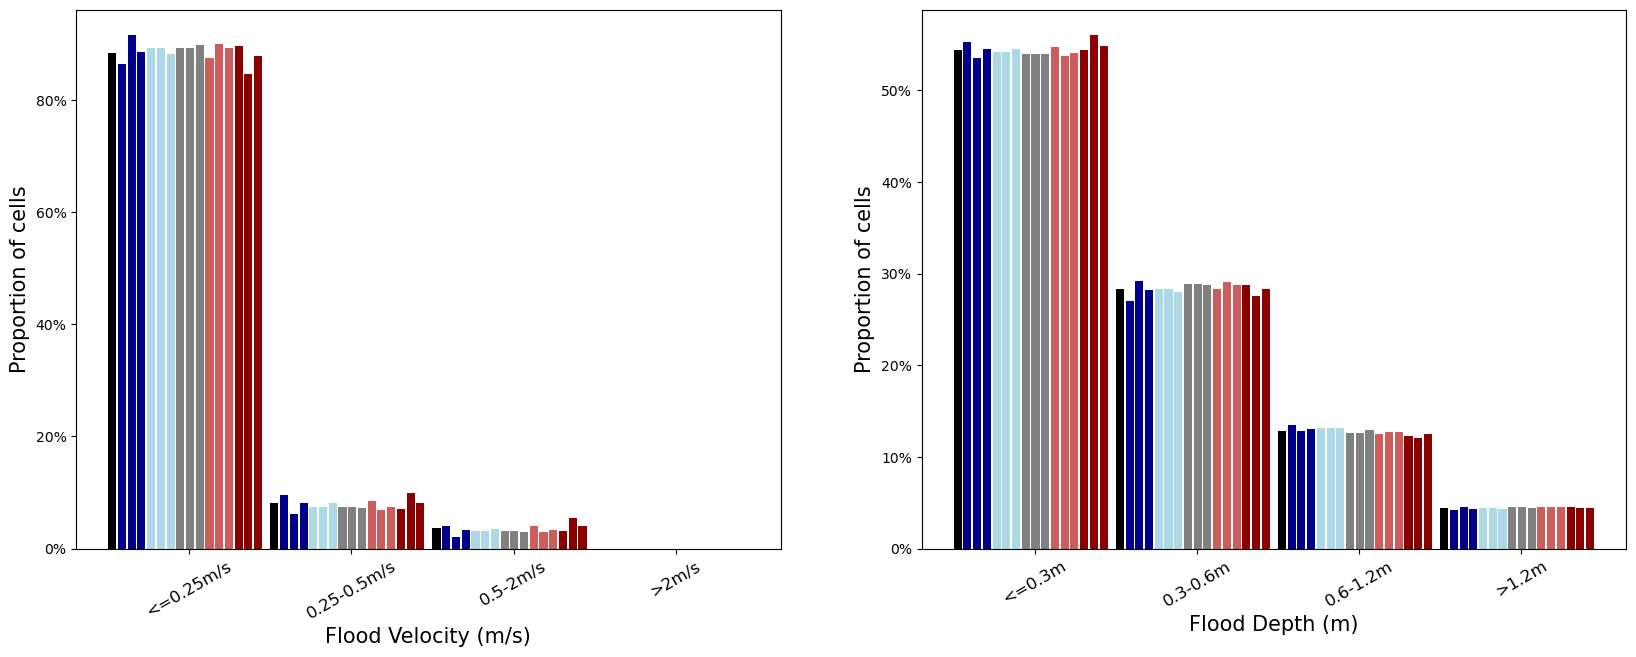

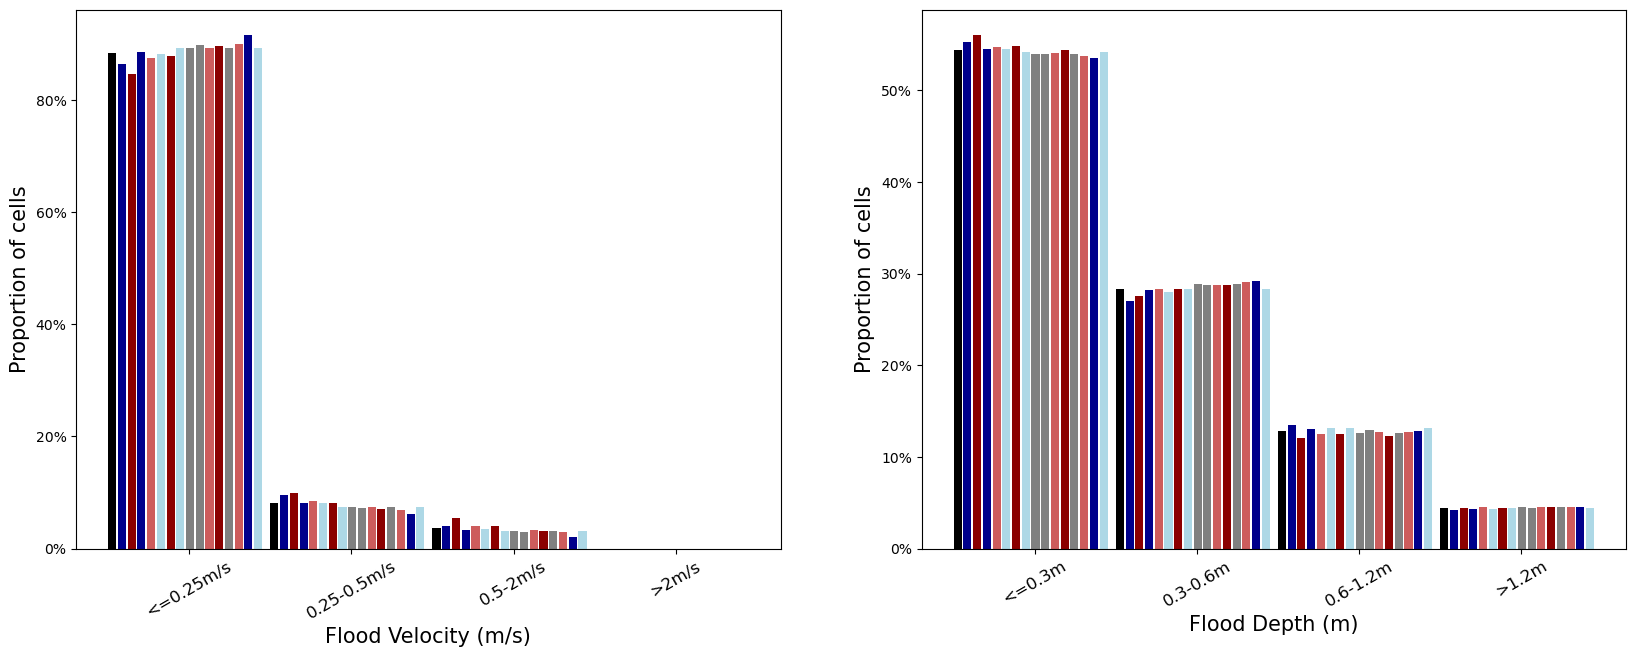

In [123]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (20,7))
bar_plot_props(axs[0],velocity_props, 'Velocity (m/s)',short_ids_by_loading, colours )
bar_plot_props(axs[1], depth_props, 'Depth (m)', short_ids_by_loading, colours)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (20,7))  
bar_plot_props(axs[0],velocity_props, 'Velocity (m/s)',short_ids_by_intensity,colours)
bar_plot_props(axs[1], depth_props, 'Depth (m)', short_ids_by_intensity, colours)

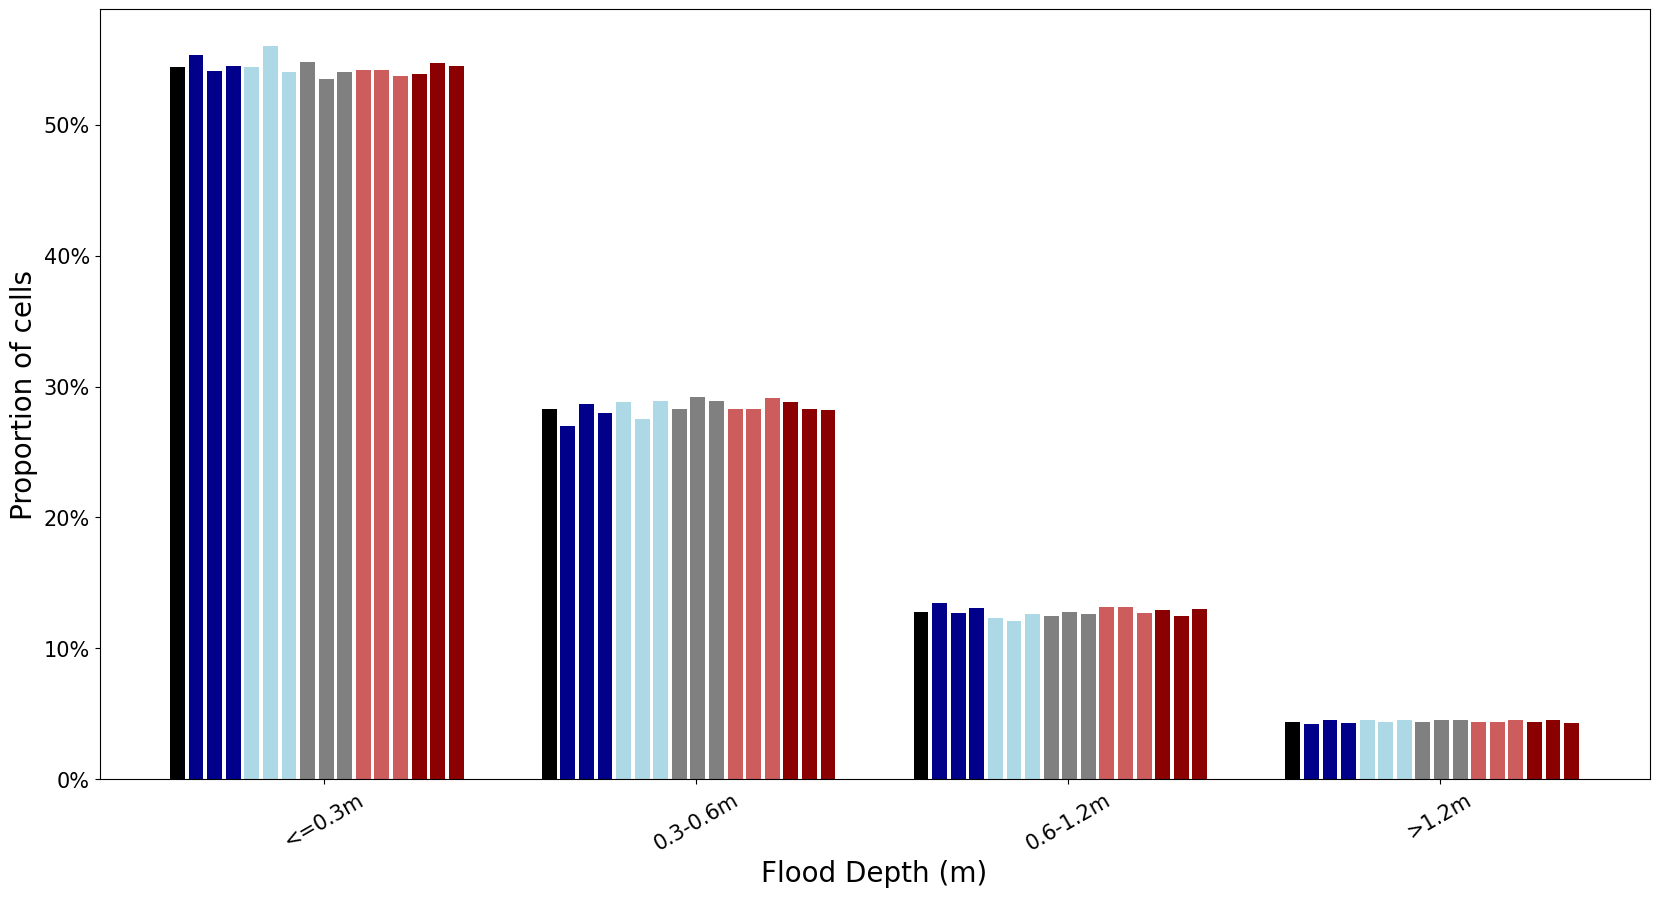

In [19]:
fig, ax =plt.subplots(figsize =(20,10))
for i in range(Num):
    plt.bar(np.arange(len(depth_counts))-WithGroupedBars/2 + (width+DistBetweenBars)*i, depth_props.iloc[:,i+1], width, 
            color = colours_formatted_ls[i])
plt.xticks(np.arange(len(depth_props['index'])), depth_props['index'], rotation=30, fontsize = 15)
plt.yticks(fontsize=15)
plt.xlabel('Flood Depth (m)', fontsize = 20)
plt.ylabel('Proportion of cells', fontsize = 20)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())

## Number of cells in which each method leads to the worst flooding (depth/velocity)
Check what happens in the case where the flood depth/velocity is equal

In [124]:
worst_case_method_depth = find_worst_case_method(fps, short_ids, 'Depth')
worst_case_method_velocity = find_worst_case_method(fps, short_ids,  'Velocity') 

In [183]:
worst_case_method_depth

,values,counts
0,6h_c1,284888
1,6h_c12,4242
2,6h_c13,3207
3,6h_c14,7197
4,6h_c15,1510
5,6h_c2,1300
6,6h_c3,121096
7,6h_c4,16662
8,6h_c5,1050480
9,6h_c7,3694


In [184]:
worst_case_method_depth = worst_case_method_depth[~worst_case_method_depth['values'].isin(['multiple matches','nan'])]
worst_case_method_velocity = worst_case_method_velocity[~worst_case_method_velocity['values'].isin(['multiple matches','nan'])]
worst_case_method_depth

,values,counts
0,6h_c1,284888
1,6h_c12,4242
2,6h_c13,3207
3,6h_c14,7197
4,6h_c15,1510
5,6h_c2,1300
6,6h_c3,121096
7,6h_c4,16662
8,6h_c5,1050480
9,6h_c7,3694


<AxesSubplot:ylabel='Number of cells'>

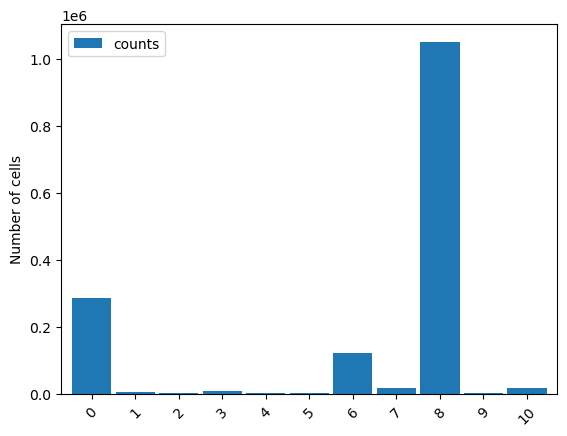

In [185]:
fig, ax  = plt.subplots()
worst_case_method_depth.plot(ax= ax, kind ='bar',width=  0.9, rot =45, ylabel = 'Number of cells')      
# def plot_worst_case_bars (ax, worst_case_method_df):
#     # Remove the np.nan values
#     worst_case_method_df = worst_case_method_df.iloc[:5,1]
#     # Set scenario names as index
#     worst_case_method_df.index = ["singlepeak", "dividetime", "subpeaktiming", "maxspread", "no maximum"]
#     # Plot
#     worst_case_method_df.plot(ax= ax, kind ='bar',width=  0.9, rot =45, ylabel = 'Number of cells')  

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize = (16,6))
plot_worst_case_bars(axs[0],worst_case_method_df)
plot_worst_case_bars(axs[1],worst_case_method_velocity)
fig.suptitle('Number cells where each method produces the deepest (left) and fastest (right) flooding', fontsize = 20)

## Spatial extent of flooding, by depth category (for d >0.1m) for each rainfall distribution

In [ ]:
# short_ids_less= ['6h_sp', '6h_dt', '6h_ms', '6h_spt', '6h_c1', '6h_c5', '6h_c8', '6h_c11', '6h_c12']
# fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(40,36))
# for number, short_id in enumerate(short_ids_less):
#     fp = 'Figs/{}/Depth_classified.png'.format(short_id)
#     make_spatial_plot(axes.flat[number],fp)
# fig.tight_layout()
# # plt.subplots_adjust(left=0.125,bottom=0.1, right=0.5, top=0.5, wspace=-0.6, hspace=0)

## Spatial extent of flooding, by velocity category (for d >0.1m) for each rainfall distribution

In [ ]:
# short_ids_less= ['6h_sp', '6h_dt', '6h_ms', '6h_spt', '6h_c1', '6h_c5', '6h_c8', '6h_c11', '6h_c12']
# fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(40,36))
# for number, short_id in enumerate(short_ids_less):
#     fp = 'Figs/{}/Velocity_classified.png'.format(short_id)
#     make_spatial_plot(axes.flat[number],fp)
# fig.tight_layout()
# plt.subplots_adjust(left=0.125,bottom=0.1, right=0.5, top=0.5, wspace=-0.6, hspace=0)

In [ ]:
# # Create discrete cmap
# colors_list = [mpl.cm.Blues(0.2), mpl.cm.Blues(0.5), mpl.cm.Blues(0.7),"navy"]
# cmap = mpl.colors.ListedColormap(colors_list)

# my_dict = {"dividetime":"Arcpy/depth_dividetime_reclassified.tif",
#            "maxspread":"Arcpy/depth_maxspread_reclassified.tif",
#            "subpeaktiming":"Arcpy/depth_subpeaktiming_reclassified.tif",
#            "singlepeak": "Arcpy/depth_singlepeak_reclassified.tif"}    

# plot_with_folium(my_dict, cmap, template_depth_cats)

In [ ]:
# # Create discrete cmap
# colors_list = [mpl.cm.cool(0.3), mpl.cm.cool(0.5), mpl.cm.cool(0.7), mpl.cm.cool(0.9)]
# cmap2 = mpl.colors.ListedColormap(colors_list)

# my_dict = {"dividetime":"Arcpy/velocity_dividetime_reclassified.tif",
#            "maxspread":"Arcpy/velocity_maxspread_reclassified.tif",
#            "subpeaktiming":"Arcpy/velocity_subpeaktiming_reclassified.tif",
#            "singlepeak": "Arcpy/velocity_singlepeak_reclassified.tif"}    

# plot_with_folium(my_dict, cmap2, template = template_velocity_cats)

## Difference in flood depth between a single peak and each of the multi-peaked methods
A positive difference implies that the flooding is deeper in the single peak method, whilst a negative difference implies the opposite.

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(35,30))
for number, short_id in enumerate(short_ids_less):
    fp = 'Figs/{}/Depth_difffromsinglepeak_classified.png'.format(short_id)
    make_spatial_plot(axes.flat[number],fp)
# for number, short_id in enumerate(short_ids_less):
#     fp = 'Figs/{}/Depth_difffromsinglepeak_posneg.png'.format(short_id)
#     make_spatial_plot(axes.flat[number+3],fp)    
fig.tight_layout()    

### Difference in flood velocity between a single peak and each of the multi-peaked methods
A positive difference implies that the flooding is deeper/faster in the single peak method, whilst a negative difference implies the opposite

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(35,30))
for number, short_id in enumerate(short_ids_less):
    fp = 'Figs/{}/Velocity_difffromsinglepeak_classified.png'.format(short_id)
    make_spatial_plot(axes.flat[number],fp)
for number, short_id in enumerate(short_ids_less):
    fp = 'Figs/{}/Velocity_difffromsinglepeak_posneg.png'.format(short_id)
    make_spatial_plot(axes.flat[number+3],fp)    
fig.tight_layout()    

In [ ]:
# # raster = prepare_rainfall_scenario_raster(fps[1].format('velocity'), remove_little_values)[0]
# # raster, out_meta = open_and_clip(fps[1].format('velocity'))

# # Read in data as array
# data = rasterio.open(fps[1].format('Velocity'))
# # Create a bounding box 
# minx, miny = 437000,  426500
# maxx, maxy = 445500, 434300
# bbox = box(minx, miny, maxx, maxy)
# # Insert the bbox into a GeoDataFrame
# geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0])
# # Re-project into the same coordinate system as the raster data
# geo = geo.to_crs(crs=CRS('EPSG:27700'))#data.crs.data

# # Next we need to get the coordinates of the geometry in such a format
# # that rasterio wants them. This can be conducted easily with following function
# def getFeatures(gdf):
#     """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
#     import json
#     return [json.loads(gdf.to_json())['features'][0]['geometry']]
# # Get the geometry coordinates by using the function.
# coords = getFeatures(geo)

# # Clip the raster with the polygon using the coords variable that we just created. Clipping the raster can be done easily 
# # with the mask function and specifying clip=True.
# clipped_array, out_transform = mask(data, shapes=coords, crop=True)

# # Set -9999 to NA
# clipped_array[clipped_array < -9998] = np.nan

# # Modify the metadata. Let’s start by copying the metadata from the original data file.
# out_meta = data.meta.copy()